In [1]:
%matplotlib inline
from os.path import join as pjoin
import matplotlib.pyplot as plt
from matplotlib import patheffects
import pandas as pd
import numpy as np
import seaborn as sns

from sktime.classification.kernel_based import RocketClassifier, Arsenal
from sklearn.preprocessing import StandardScaler

from stndata import ONEMINUTESTNNAMES

np.random.seed(1000)


Load the stations, and the manual storm classification data. That data is stored in a separate csv file, indexed by date and station number. We then split the storm data into a training set and a test set. Bear in mind this is still the subset of high quality stations. There's another 500-odd stations that we have processed to extract daily maximum wind gust data.

In [2]:
BASEDIR = r"X:\georisk\HaRIA_B_Wind\data\derived\obs\1-minute\events"

stndf = pd.read_csv(pjoin(BASEDIR, 'hqstations.csv'), index_col="stnNum")

eventFile = pjoin(BASEDIR, "CA_20230518_Hobart.csv")
#eventFile = pjoin(BASEDIR, "NA_all.csv")
stormdf = pd.read_csv(eventFile, usecols=[1, 2, 3], parse_dates=['date'],
                      dtype={'stnNum': int,
                             'stormType': 'category'})

#stormdf = pd.read_csv(eventFile, usecols=[2, 3, 4], parse_dates=['date'],
#                dtype={'stnNum': float,
#                       'stormType': 'category'},
#                converters={'stnNum': lambda s: int(float(s.strip() or 0))})

stormdf.set_index(['stnNum', 'date'], inplace=True)
nevents = len(stormdf)

# Take a random selection of 200 storms to test against:
test_storms = stormdf.sample(200)
train_storms = stormdf.drop(test_storms.index)
ntrain = len(train_storms)

In [3]:
import sklearn; sklearn.__version__

'1.4.0'

In [6]:
def loadData(stnNum: int) -> pd.DataFrame:
    """
    Load event data for a given station. Missing values are interpolated
    linearly - if values are missing at the start or end they are backfilled
    from the nearest valid value.

    This data has been extracted by `extractStationData.py`, and is stored in
    pickle files, so there should be no issues around type conversions.

    :param stnNum: BoM station number
    :type stnNum: int
    :return: DataFrame holding the data of all gust events for a station
    :rtype: `pd.DataFrame`
    """
    fname = pjoin(BASEDIR, "events", f"{stnNum:06d}.pkl")
    df = pd.read_pickle(fname)
    df['date'] = pd.to_datetime(df['date'])
    df['windgust'] = df['windgust'].interpolate(method='linear').bfill()
    df['tempanom'] = df['tempanom'].interpolate(method='linear').bfill()
    df['stnpanom'] = df['stnpanom'].interpolate(method='linear').bfill()
    df['dpanom'] = df['dpanom'].interpolate(method='linear').bfill()
    df['windspd'] = df['windspd'].interpolate(method='linear').bfill()
    df['uanom'] = df['uanom'].interpolate(method='linear').bfill()
    df['vanom'] = df['vanom'].interpolate(method='linear').bfill()
    vars = ['windgust', 'tempanom', 'stnpanom',
            'dpanom', 'windspd', 'uanom', 'vanom']

    #for idx, tmpdf in df.groupby('date'):
    #    scaler = StandardScaler()
    #    scalevals = scaler.fit_transform(tmpdf[vars].values)
    #    df.loc[df['date'] == idx, vars] = scalevals

    df['stnNum'] = stnNum
    df.reset_index(inplace=True)
    df.set_index(['stnNum', 'date'], inplace=True)

    return df

Load all the events into a single dataframe. We'll then pick out the events based on whether they are in the training set or the test set, using the index from the storm classification data

In [7]:
dflist = []
for stn in stndf.index:
    df = loadData(stn)
    dflist.append(df)

alldf = pd.concat(dflist)
alldf['idx'] = alldf.index

Split the event data into training and test datasets. This is simple because we set the index of both the event data and the storm classification data to be the station number and date of the event. 

The event data needs to be reshaped into a 3-d array (for input into the classifier), where there are n events in the first dimension. The second dimension represents the time (-60 minutes to +60 minutes) and the third dimension represents the different variables. We can potentially vary the list of variables used, but we start with the wind gust and the anomalies of temperature, dewpoint and station pressure.

In [8]:
eventdf_train = alldf.loc[train_storms.index]
eventdf_test = alldf.loc[test_storms.index]

vars = ['windgust', 'tempanom', 'stnpanom', 'dpanom']
scaler = StandardScaler()
eventdf_train[vars] = scaler.fit_transform(eventdf_train[vars].values)
eventdf_test[vars] = scaler.transform(eventdf_test[vars].values)

nvars = len(vars)
X = eventdf_train.reset_index().set_index(['idx', 'tdiff'])[vars]
XX = np.moveaxis(X.values.reshape((ntrain, 121, nvars)), 1, -1)

X_test = eventdf_test.reset_index().set_index(['idx', 'tdiff'])[vars]
XX_test = np.moveaxis(X_test.values.reshape((200, 121, nvars)), 1, -1)

fulltest = alldf.loc[stormdf.index].reset_index().set_index(['idx', 'tdiff'])[vars]
fulltestarray = np.moveaxis(fulltest.values.reshape((len(stormdf), 121, nvars)), 1, -1)
fully = np.array(list(stormdf.loc[fulltest.reset_index()['idx'].unique()]['stormType'].values))

y = np.array(train_storms['stormType'].values)

Here's where we train and run the classifier on the test event set. The classifier is fitted to the training data (`XX`), then we predict the class of the test data (`XX_test`). Results are compared to the visual classification of the test data.

In [9]:
rocket = RocketClassifier(num_kernels=10000)
rocket.fit(XX, y)

RocketClassifier()

In [10]:
from sktime.transformations.panel.rocket import Rocket
trf = Rocket()
trf.fit(XX)

Rocket()

In [12]:
def _apply_kernel_univariate(X, weights, length, bias, dilation, padding):
    n_timepoints = len(X)

    output_length = (n_timepoints + (2 * padding)) - ((length - 1) * dilation)

    _ppv = 0
    _max = np.NINF

    end = (n_timepoints + padding) - ((length - 1) * dilation)

    for i in range(-padding, end):
        _sum = bias

        index = i

        for j in range(length):
            if index > -1 and index < n_timepoints:
                _sum = _sum + weights[j] * X[index]

            index = index + dilation

        if _sum > _max:
            _max = _sum

        if _sum > 0:
            _ppv += 1

    return np.float32(_ppv / output_length), np.float32(_max)

def _apply_kernel_multivariate(
    X, weights, length, bias, dilation, padding, num_channel_indices, channel_indices
):
    n_columns, n_timepoints = X.shape

    output_length = (n_timepoints + (2 * padding)) - ((length - 1) * dilation)

    _ppv = 0
    _max = np.NINF

    end = (n_timepoints + padding) - ((length - 1) * dilation)

    for i in range(-padding, end):
        _sum = bias

        index = i

        for j in range(length):
            if index > -1 and index < n_timepoints:
                for k in range(num_channel_indices):
                    _sum = _sum + weights[k, j] * X[channel_indices[k], index]

            index = index + dilation

        if _sum > _max:
            _max = _sum

        if _sum > 0:
            _ppv += 1

    return np.float32(_ppv / output_length), np.float32(_max)

In [13]:
def apply_kernels(X, kernels):
    (
        weights,
        lengths,
        biases,
        dilations,
        paddings,
        num_channel_indices,
        channel_indices,
    ) = kernels

    n_instances, n_columns, _ = X.shape
    num_kernels = len(lengths)

    _X = np.zeros(
        (n_instances, num_kernels * 2), dtype=np.float32
    )  # 2 features per kernel

    for i in range(n_instances):
        a1 = 0  # for weights
        a2 = 0  # for channel_indices
        a3 = 0  # for features

        for j in range(num_kernels):
            b1 = a1 + num_channel_indices[j] * lengths[j]
            b2 = a2 + num_channel_indices[j]
            b3 = a3 + 2

            if num_channel_indices[j] == 1:
                _X[i, a3:b3] = _apply_kernel_univariate(
                    X[i, channel_indices[a2]],
                    weights[a1:b1],
                    lengths[j],
                    biases[j],
                    dilations[j],
                    paddings[j],
                )

            else:
                _weights = weights[a1:b1].reshape((num_channel_indices[j], lengths[j]))

                _X[i, a3:b3] = _apply_kernel_multivariate(
                    X[i],
                    _weights,
                    lengths[j],
                    biases[j],
                    dilations[j],
                    paddings[j],
                    num_channel_indices[j],
                    channel_indices[a2:b2],
                )

            a1 = b1
            a2 = b2
            a3 = b3

    return _X.astype(np.float32), _weights

In [14]:
XX_, weights = apply_kernels(XX, trf.kernels)

In [16]:
trf.kernels

(array([-0.8935588 , -1.6196154 ,  2.2677436 , ..., -1.3314456 ,
        -0.13774604, -0.43073913], dtype=float32),
 array([ 9, 11, 11, ..., 11,  9,  9]),
 array([ 0.74477357, -0.48178563, -0.483774  , ...,  0.54491574,
         0.43761113, -0.26604533], dtype=float32),
 array([4, 5, 2, ..., 1, 1, 1]),
 array([16, 25, 10, ...,  0,  4,  4]),
 array([4, 1, 1, ..., 1, 3, 1]),
 array([2, 0, 1, ..., 3, 0, 2]))

So the `weights` variable that is returned by my `apply_kernels` function above is the weights for the last kernel, which has length 7, a bias of -0.556, dilation 17 and padding 51. So what we're seeing when we plot `weights` is the weight given to each variable for the kernel element.

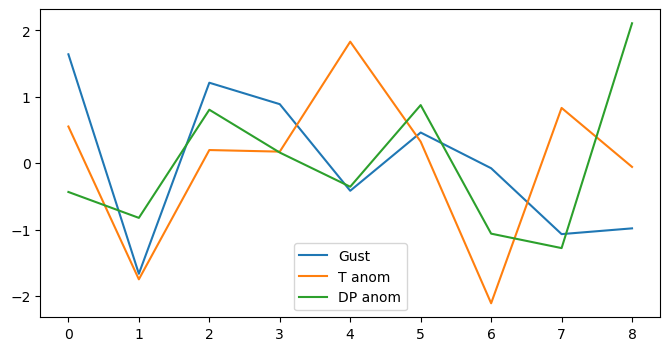

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
lines = ax.plot(weights.T)

vars = ['Gust', 'T anom', 'DP anom', 'Prs anom']
for l, v in zip(lines, vars):
    l.set_label(v)
ax.legend()